# Отчёт о проведении эксперимента: CFPQ

  Исходные данные: датасеты `MemoryAliases`, `FullGraph`, `WorstCase`. Запуск на `SparseGraph` не удался, т.к. даже на самом маленьком графе время работы Hellings превысило 15 часов, хотя это и не исключает того, что алгоритм Matrices отработал бы намного быстрее - но и сравнивать его тогда было бы не с чем.

  Замеры времени произведены на ЭВМ с установленной ОС Ubuntu 20.04. Технические характеристики: AMD Ryzen™ 5 4600U 2.1 GHz (max 4.0 GHz), 3Mb L2 Cache, 6 cores (12 threads); 16 Gb DDR4 RAM.
  
  Для каждого замера в наносекундах запуск алгоритма производился 1-2 раза (в силу длительного времени работы каждого алгоритма, а также того, что разница между алгоритмам и так довольно значительная, поэтому настолько точная оценка средним с дисперсией просто не нужна), в итоговую таблицу записаны значения округлённое до миллисекунд. На графиках для большей репрезентативности время указано в секундах.
  
  Для контроля корректности использовалось количество достижимых пар вершин в графе, пути между которыми лежат в языке, порожденном заданной в запросе грамматикой. Результаты тестов показали, что оно совпадало для разных алгоритмов на одном и том же запросе (использовались `assert`).
  
  Процесс постановки эксперимента: 
   - Сначала производился **замер времени построения CNF из файла с исходной грамматикой**, содержащей регулярные выражения (Regex -> EpsilonNFA -> DFA -> minimize -> CFG-for-production -> CNF-for-production)
   - Далее **замер построения рекурсивного автомата сразу по исходной грамматике** (Regex -> EpsilonNFA -> DFA -> minimize -> Recursive Finite Automaton (RFA) )
   - Потом шли замеры работы алгоритмов: 
     - **Hellings на CNF**
     - **Matrices на CNF**
     - **Tensors на CFG** (внутри с преобразованием CFG -> RFA)
     - **Tensors на CNF** (внутри с преобразованием CNF -> RFA)
     - **Tensors на RFA** (построенным сразу по исходной грамматике)
   - Необходимо заметить, что построенные указанным образом CFG и CNF по исходной грамматике с **регулярными выражениями** отличаются слабо, так как оба содержать продукции, где в большинстве случае в теле всего две переменных. Это объясняет то, что разница во времени между одним и тем же алгоритмом, запущенном на них, незначительная (например, cfg_tensors и cnf_tensors). Можно было бы преобразовывать указанным образом грамматику только в том случае, когда там есть регексы, это было бы хорошей оптимизацией в принципе, но в данном бенчмарке разницы нет, ведь сравниваем мы все равно относительное время работы алгоритмов, а не преобразования грамматик. Однако это могло бы уравнять шансы rfa_tensors с cfg_tensors/cnf_tensors.

Сводная таблица, полученная после запуска бенчмарков на датасетах:

In [140]:
import pandas as pd
import seaborn as sns
import numpy as np

sns.set(rc={'figure.figsize':(13,9)})


df = pd.read_csv('cfpq_benchmark.csv')

# Translate time in milliseconds to time in seconds
df['cnf_load_time'] = df['cnf_load_time'] / 1e3
df['rfa_load_time'] = df['rfa_load_time'] / 1e3
df['cnf_hellings_time'] = df['cnf_hellings_time'] / 1e3
df['cnf_matrices_time'] = df['cnf_matrices_time'] / 1e3
df['cfg_tensors_time'] = df['cfg_tensors_time'] / 1e3
df['cnf_tensors_time'] = df['cnf_tensors_time'] / 1e3
df['rfa_tensors_time'] = df['rfa_tensors_time'] / 1e3

# Calculate total time per algorithm
df['hellings'] = df['cnf_load_time'] + df['cnf_hellings_time']
df['matrices'] = df['cnf_load_time'] + df['cnf_matrices_time']
df['cfg_tensors'] = df['cnf_load_time'] + df['cfg_tensors_time']
df['cnf_tensors'] = df['cnf_load_time'] + df['cnf_tensors_time']
df['rfa_tensors'] = df['rfa_load_time'] + df['rfa_tensors_time']

df = df.drop(['cnf_load_time', 'rfa_load_time', 'cnf_hellings_time', 'cnf_matrices_time', 
         'cfg_tensors_time', 'cnf_tensors_time', 'rfa_tensors_time'], axis=1)

df.head(50)

,suite,graph,grammar,hellings,matrices,cfg_tensors,cnf_tensors,rfa_tensors
0,MemoryAliases,wc.txt,g2,2.642,0.007,4.513,5.158,0.078
1,MemoryAliases,wc.txt,g1,3.979,0.008,41.037,6.986,1.153
2,MemoryAliases,gzip.txt,g2,93.449,0.021,1014.493,1446.182,24.913
3,MemoryAliases,gzip.txt,g1,98.252,0.025,4742.002,1256.461,177.266
4,MemoryAliases,pr.txt,g2,14.818,0.011,65.530,98.712,1.315
5,MemoryAliases,pr.txt,g1,18.291,0.013,398.245,111.137,13.822
6,MemoryAliases,ls.txt,g2,156.666,0.031,605.922,731.118,9.507
7,MemoryAliases,ls.txt,g1,159.786,0.035,3429.781,911.291,95.854
8,MemoryAliases,bzip2.txt,g2,12.038,0.015,66.788,92.713,0.797
9,MemoryAliases,bzip2.txt,g1,16.003,0.015,472.340,117.958,13.740


Преобразуем данные из сводной таблицы (по сути, у нас на руках pivot_table) в удобный вид для отрисовки графиков:

In [141]:
unpivot = pd.melt(df, id_vars=['suite', 'graph', 'grammar'], 
                  value_vars=['hellings', 'matrices', 'cfg_tensors', 'cnf_tensors', 'rfa_tensors'],
                  var_name='algo', value_name='time')
unpivot.head(10)

,suite,graph,grammar,algo,time
0,MemoryAliases,wc.txt,g2,hellings,2.642
1,MemoryAliases,wc.txt,g1,hellings,3.979
2,MemoryAliases,gzip.txt,g2,hellings,93.449
3,MemoryAliases,gzip.txt,g1,hellings,98.252
4,MemoryAliases,pr.txt,g2,hellings,14.818
5,MemoryAliases,pr.txt,g1,hellings,18.291
6,MemoryAliases,ls.txt,g2,hellings,156.666
7,MemoryAliases,ls.txt,g1,hellings,159.786
8,MemoryAliases,bzip2.txt,g2,hellings,12.038
9,MemoryAliases,bzip2.txt,g1,hellings,16.003


In [92]:
def get_barplot(suite, grammar, order=None):
    current_df = unpivot[(unpivot['suite'] == suite) & (unpivot['grammar'] == grammar)]
    if not order:
        order = np.sort(current_df['graph'].unique())
    plot = sns.barplot(x='graph', y='time', hue='algo', order=order, data=current_df)
    plot.set_yscale('log')
    plot.set_title(f'{suite} suite, grammar = <{grammar}>')
    plot.set(xlabel='Graph filename', ylabel='Time, s')
    return plot

### MemoryAliases

Рассмотрим результаты на датасете MemoryAliases, отдельно для грамматик g1 и g2:

<AxesSubplot:title={'center':'MemoryAliases suite, grammar = <g1>'}, xlabel='Graph filename', ylabel='Time, s'>

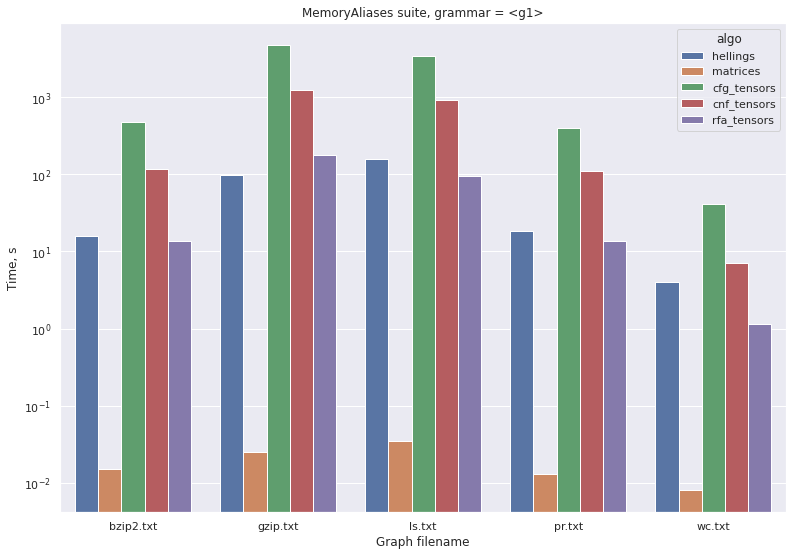

In [94]:
get_barplot('MemoryAliases', 'g1')

<AxesSubplot:title={'center':'MemoryAliases suite, grammar = <g2>'}, xlabel='Graph filename', ylabel='Time, s'>

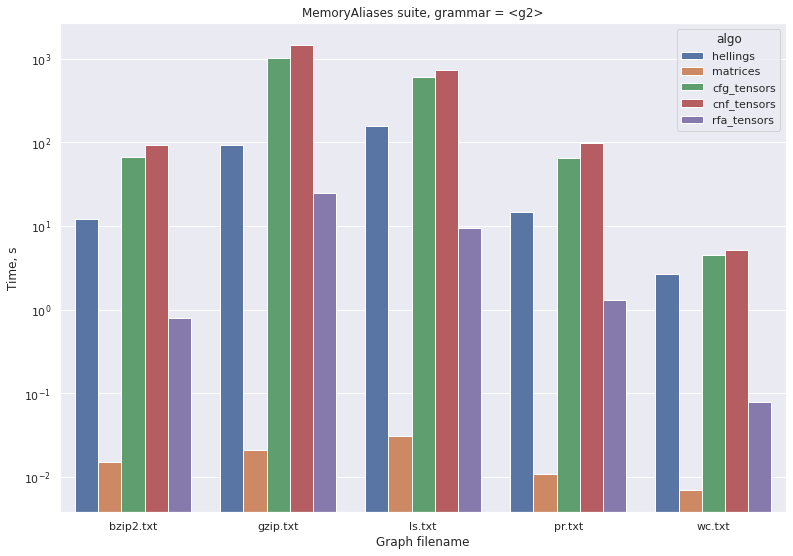

In [95]:
get_barplot('MemoryAliases', 'g2')

Как можно заметить, алгоритм с умножением матриц выигрыват по времени с огромным отрывом у всех остальных (из-за него даже пришлось вводить логарифмическую шкалу времени). Интересно сравнить реализации других алгоритмов: если же Хеллингс и тензорный алгоритм на CFG и CNF работают почти одинаково долго, то реализация тензорного алгоритма вместе с преобразованием исходной грамматики сразу к RFA спасает положение. Отчасти, это возможно из-за увеличения количества продукций в грамматиках с регулярными выражениями, тогда как RFA сразу преобразовывает их в граф, сокращая потенциальное количество ребер. Также заметно, что для `g1`, гда грамматика простая (без регулярных выражений), RFA почти такой же, как и Хеллингс, но когда грамматика со сложным регулярным выражением (`g2`), тензоры с RFA намного быстрее, что объясняется непосредственным преобразованием, описанным выше. Но до матриц ему все равно далеко, это, вполне вероятно, обусловлено очень эффективной реализацией умножения разреженных матриц в библиотеке `GraphBLAS`.

### FullGraph

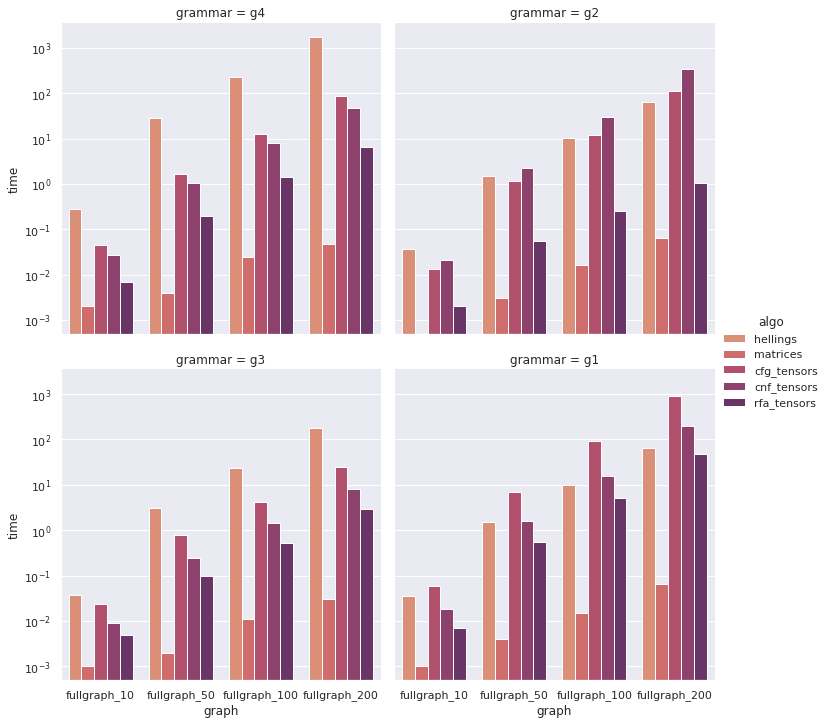

In [135]:
fullgraphs_order=['fullgraph_10', 'fullgraph_50', 'fullgraph_100', 'fullgraph_200']

catplot = sns.catplot(x="graph", y="time", hue="algo", order=fullgraphs_order, palette="flare",
            data=unpivot[unpivot["suite"] == "FullGraph"], col="grammar", col_wrap=2,
            kind="bar").set(yscale="log")

Время опять указано в секундах, шкала логарифмическая. В целом, ничего нового, грамматики в этом наборе необъёмные, TensorRFA почти не выделяется на фоне остальных, но все еще быстрее TensorCFG и TensorCNF. Алгоритм с умножением матриц также в разы быстрее остальных.

### WorstCase

<AxesSubplot:title={'center':'WorstCase suite, grammar = <g1>'}, xlabel='Graph filename', ylabel='Time, s'>

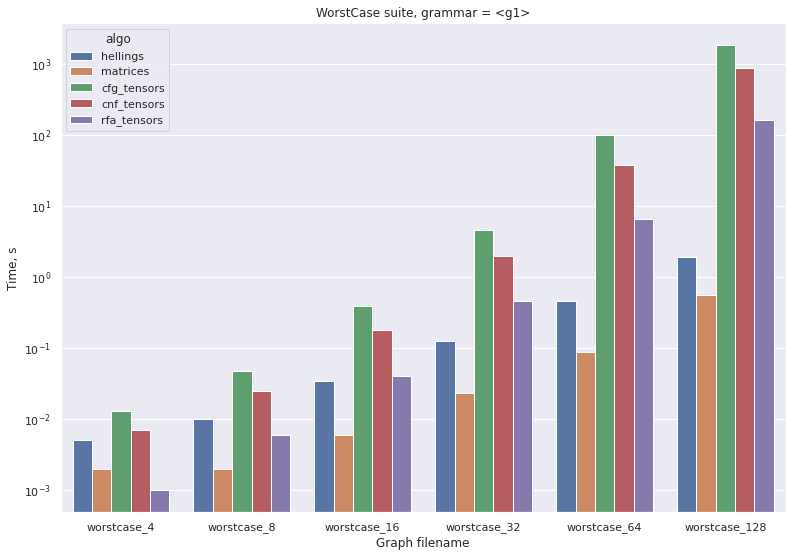

In [136]:
get_barplot('WorstCase', 'g1', order=[f'worstcase_{power}' for power in [4, 8, 16, 32, 64, 128]])

Аналогичная ситуация. Интересно отметить, что время работы алгоритмов экспоненциально зависит от размера графа (который виден из названия), и в целом распределение времени по алгоритмам почти одинаковое каждый раз. Из этого можно построить гипотезу о том, что данные в наборе WorstCase синтетические и смоделированы одним и тем же алгоритмом.  

Таким образом:

 - Матричный алгоритм остаётся самым быстрым при работе на всех трёх проверенных датасетах, и есть основания полагать, что и на SparseGraph тоже. Обсуловленно это, скорее всего, эффективной реализацией матричных вычислений с умным использованием вычислительных ресурсов CPU в `GraphBLAS`.
 - Тензорный алгоритм, преобразующий внутри себя грамматику из CNF (или исходной CFG, но с короткими продукциями из-за регексов) в рекурсивный автомат, обычно работает дольше всех. Однако если преобразовывать грамматику из исходной в рекурсивный автомат сразу же, на стадии препроцессинга, это очень сильно ускоряет его работу, особенно с грамматиками, содержащими сложные регексы. Тут с точностью до условности, описанной во описании постановки эксперимента.
 - Алгоритм Хеллингса сравним в большинстве случаев по времени с тензорным, где-то немного обходит его, где-то немного проигрывает. Более конкретных выводом по нему сделать не представляется возможным.